
# Deep Learning Frameworks

AY 128 (UC Berkeley; 2012-2025)


Almost all frameworks written in low-level C++/C with Python (or other scripting bindings)

### Low-level frameworks

   - Tensorflow (Google) Nov 2015. See https://www.tensorflow.org/api_docs/python/tf
   - pytorch (Python). https://pytorch.org/docs/stable/index.html
   - Theano
   - Caffe (Berkeley)
   - Torch (Lua)
   - CNTK (Microsoft)
   - Chainer
   - PaddlePaddle (Baidu) Aug 2016
   
### High-level frameworks (Python)

   - Keras (atop Tensorflow, Theano) - https://www.tensorflow.org/api_docs/python/tf/keras
   - Skorch - scikit-learn compatible neural network library that wraps PyTorch (https://github.com/skorch-dev/skorch)
   - FastAI: https://docs.fast.ai/
   - PyTorch Lightning (https://github.com/PyTorchLightning/pytorch-lightning)
   
<img src="figs/frameworks.png" width="75%">
Source: https://paperswithcode.com/trends


see also: https://github.com/mbadry1/Top-Deep-Learning

<img src="http://www.asimovinstitute.org/wp-content/uploads/2016/09/neuralnetworks.png">

Source: http://www.asimovinstitute.org/neural-network-zoo/

An example (from Josh's student work): 

<img src="https://github.com/profjsb/deepCR/raw/master/imgs/network.png">

<img src="https://raw.githubusercontent.com/profjsb/deepCR/master/imgs/postage-sm.jpg">

"deepCR: Deep Learning Based Cosmic Ray Removal for Astronomical Images"
https://github.com/profjsb/deepCR

# PyTorch

   - syntax closely resembles Python, making it easy for developers familiar with the language to transition to deep learning.
   - Dynamic Computational Graphs:
Unlike some frameworks that require you to define the entire computation graph upfront (static graphs), PyTorch builds the graph on the fly as you execute your code. This makes debugging easier and allows for more flexibility, especially in research settings where rapid prototyping is crucial.
   - PyTorch leverages the power of GPUs to accelerate computations, making it suitable for training large and complex models efficiently.                                                                           

Let's load up the California housing data as in the previous notebook.

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn import datasets
from sklearn.preprocessing import StandardScaler  

cal_data = datasets.fetch_california_housing()
X = cal_data['data']   # 8 features 
Y = cal_data['target'] # response (median house price)

half = math.floor(len(Y)/2)
train_X = X[:half]
train_Y = Y[:half]
test_X = X[half:]
test_Y = Y[half:]

# scale the data; remove mean and scale to unit variance: z = (x - u) / s
# StandardScaler transforms your data such that its distribution will have a mean value 0 and standard deviation of 1
scaler = StandardScaler()  

# Don't cheat - fit only on training data
scaler.fit(train_X)  
train_X = scaler.transform(train_X)  

# apply same transformation to test data
test_X = scaler.transform(test_X)

In [2]:
test_X[0,:]

array([ 1.83091342, -1.31085329,  0.84047027, -0.15023587,  0.25295181,
        0.0466981 , -0.83013107,  0.92616793])

In [3]:
num_input_features = train_X.shape[1]
print(f'number of input features = {num_input_features}')

number of input features = 8


In [4]:
import datetime, os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Print torch version
print(torch.__version__)

2.7.1


Let's make a simple neural network in PyTorch, as an MLP (multi-layer perceptron) with
a few layers.

In [5]:
class NNClf(nn.Module):
    """
    A simple neural network classifier using PyTorch.

    This class defines a neural network with three hidden layers and one output layer.
    It uses ReLU (Rectified Linear Unit) activation function for the hidden layers.

    Attributes:
    -----------
    layer1 : nn.Linear
        The first linear layer which takes input features and maps them to 32 neurons.
    layer2 : nn.Linear
        The second linear layer which takes 32 neurons from the first layer and maps them to another 32 neurons.
    layer3 : nn.Linear
        The third linear layer which takes 32 neurons from the second layer and maps them to 10 neurons.
    output_layer : nn.Linear
        The output layer which takes 10 neurons from the third layer and maps them to a single output.

    Methods:
    --------
    forward(x):
        Defines the forward pass of the neural network. It takes an input tensor `x` and passes it through
        the layers with ReLU activation functions in between, and finally through the output layer.
    """
    def __init__(self, input_features):
        super(NNClf, self).__init__()
        self.layer1 = nn.Linear(input_features, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output_layer(x)
        return x

In [6]:
model = NNClf(num_input_features)
print(model)

NNClf(
  (layer1): Linear(in_features=8, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)


In [7]:
# Convert numpy arrays to PyTorch tensors
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_Y_tensor = torch.tensor(train_Y, dtype=torch.float32).view(-1, 1)  # reshape to a 2D tensor
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_Y_tensor = torch.tensor(test_Y, dtype=torch.float32).view(-1, 1)

In [8]:
print(train_Y_tensor.size())
print(train_Y.shape)

torch.Size([10320, 1])
(10320,)


## Datasets & DataLoaders

"Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples."

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [9]:
TensorDataset?

Init signature: TensorDataset(*tensors: torch.Tensor) -> None
Docstring:     
Dataset wrapping tensors.

Each sample will be retrieved by indexing tensors along the first dimension.

Args:
    *tensors (Tensor): tensors that have the same size of the first dimension.
File:           ~/.local/share/mamba/envs/astrods/lib/python3.11/site-packages/torch/utils/data/dataset.py
Type:           type
Subclasses:     

In [10]:
DataLoader?

Init signature:
DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+_T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, collections.abc.Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[list], collections.abc.Iterable[list], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[list[~_T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: Optional[int] = None,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
    in_order: bool = True,
)
Docstring:     
Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style

In [11]:
# Create Dataset DataLoader
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
# Define loss and optimizer

# The criterion is defined as Mean Squared Error (MSE) Loss, which is a common loss function 
# used for regression tasks. It measures the average squared difference between the 
# estimated values and the actual value.
criterion = nn.MSELoss()

# The optimizer is defined as Adam (Adaptive Moment Estimation) optimizer, which is an 
# algorithm for first-order gradient-based optimization of stochastic objective functions. 
# It is configured to optimize the parameters of the model with a learning rate of 0.001.
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training loop
epochs = 50  # Number of epochs to train the model

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    
    # Iterate over batches of data from the training loader
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        outputs = model(batch_X)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, batch_Y)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
    print(f"{loss.item():0.3f}", sep=" ", end=" ", flush=True)

0.229 0.258 0.167 0.274 0.151 0.205 0.387 0.202 0.125 0.343 0.115 0.141 0.142 0.201 0.087 0.128 0.357 0.165 0.234 0.195 0.437 0.583 0.288 0.137 0.203 0.132 0.476 0.077 0.058 0.129 0.125 0.119 0.102 0.063 0.203 0.147 0.092 0.246 0.209 0.232 0.083 0.060 1.039 0.051 0.110 0.262 0.127 0.496 0.049 0.116 

In [14]:
# Evaluate the model
model.eval()  # set outselves in evaluation mode
with torch.no_grad():
    predictions = model(test_X_tensor).numpy()

In [15]:
# Calculate MSE
mse = np.mean((predictions - test_Y_tensor.numpy()) ** 2)
print("MSE", mse)

MSE 0.5013686


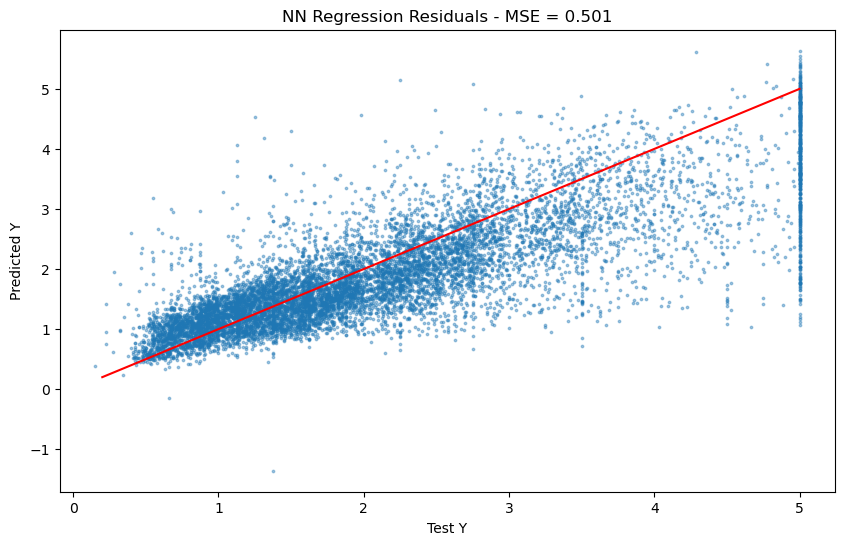

In [16]:
# how well did we do?
import numpy as np

plt.figure(figsize=(10,6))
plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(test_Y_tensor.numpy(), predictions, alpha=0.4, s=3)
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")
plt.plot([0.2, 5], [0.2, 5], c="r")